In [57]:
import pandas as pd
import matplotlib.pyplot as plt

import nbimporter

from plot_utils import plot_orders

In [ ]:
start_pnt = (37.48447, 126.48626)


C:\Users\yana\anaconda3\envs\study_ai\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


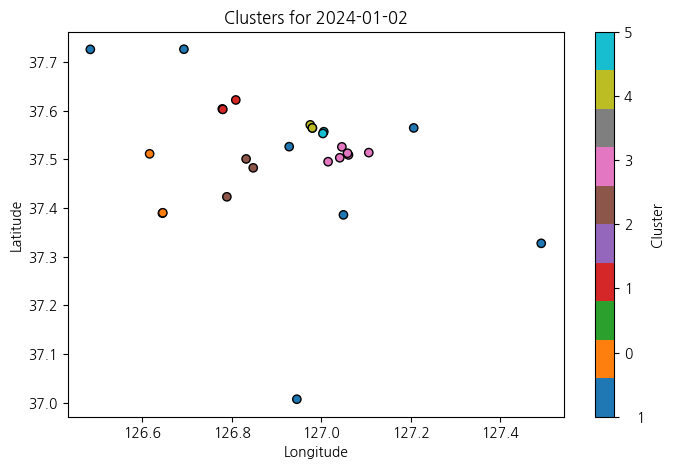

C:\Users\yana\anaconda3\envs\study_ai\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


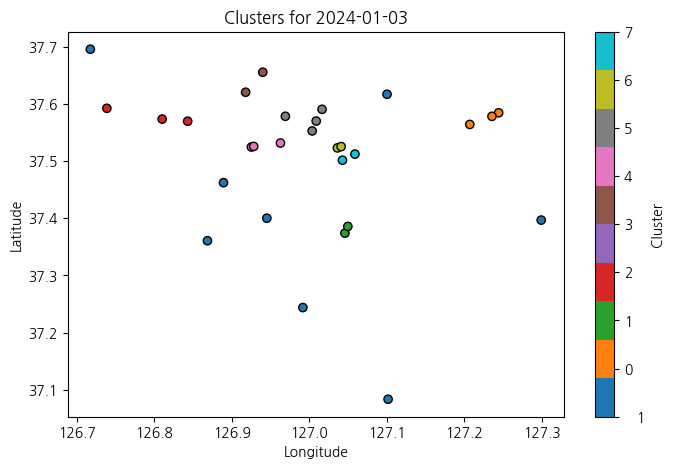

C:\Users\yana\anaconda3\envs\study_ai\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


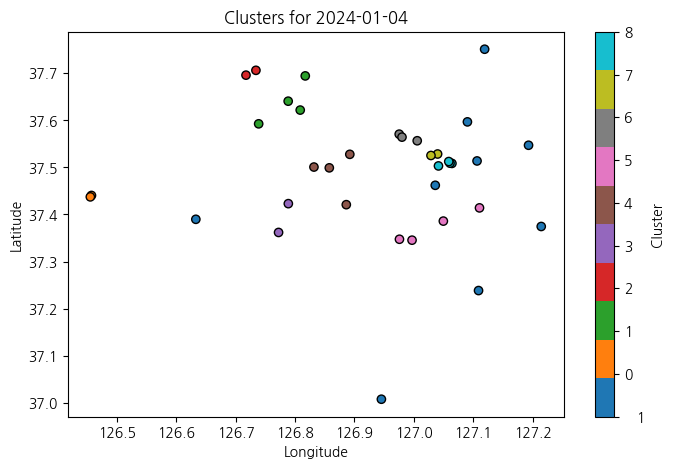

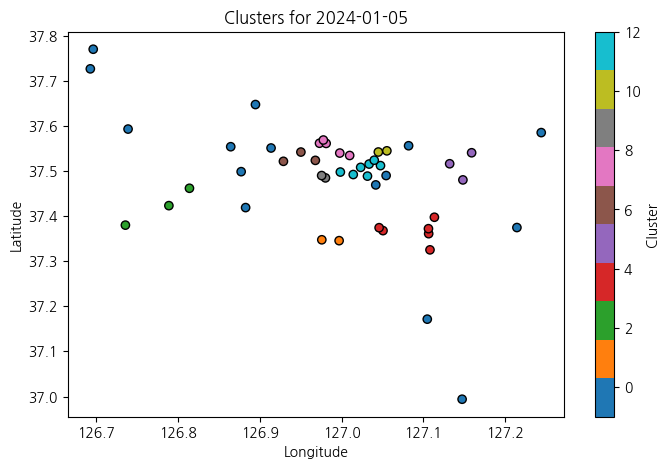

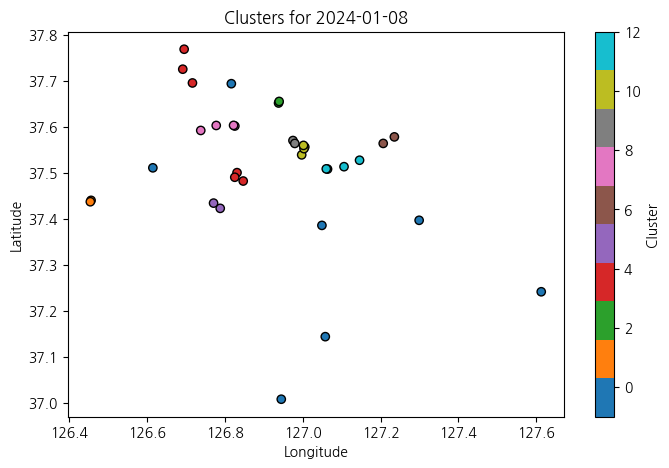

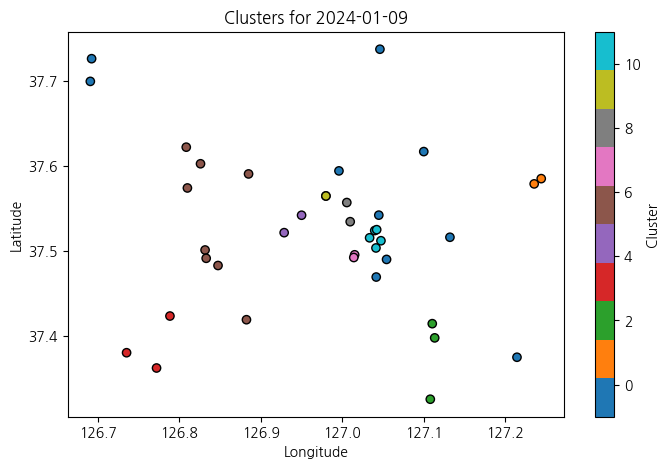

C:\Users\yana\anaconda3\envs\study_ai\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


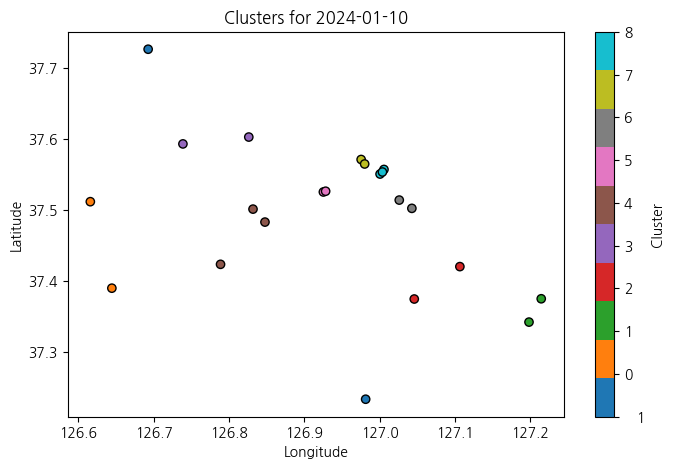

In [101]:
# Load.
df = pd.read_csv('./data/Hennessy_clustering_results_13.csv')
df = df[['date', 'latitude', 'longitude']]

# Feature scaling.
# from sklearn.preprocessing import MinMaxScaler
# sclr = MinMaxScaler()
# df[['latitude_norm', 'longitude_norm']] = sclr.fit_transform(df[['latitude', 'longitude']])

# Cluster.
from sklearn.cluster import HDBSCAN
model = HDBSCAN(min_samples=2,
                min_cluster_size=2,
                max_cluster_size=10,
                cluster_selection_epsilon=2e-2,
                cluster_selection_method='leaf',
                metric='haversine',
                alpha=0.1)

for date, df_date in df.groupby('date'):
    idx = df_date.index
    x   = df_date[['latitude', 'longitude']].to_numpy()

    df.loc[idx, 'cluster'] = model.fit_predict(x)

# Plot.
date_range = pd.date_range("2024-01-02", "2024-01-10").strftime('%Y-%m-%d')

for date_plot in date_range:
    df_plot = df.query("date == @date_plot")
    
    if len(df_plot) < 5:
        continue  
    
    plt.figure(figsize=(8, 5))
    scatter = plt.scatter(df_plot['longitude'], 
                          df_plot['latitude'], 
                          c=df_plot['cluster'], 
                          cmap='tab10', 
                          alpha=1.0, 
                          edgecolors='k')
    
    plt.colorbar(scatter, label='Cluster')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title(f'Clusters for {date_plot}')
    
    plt.show()


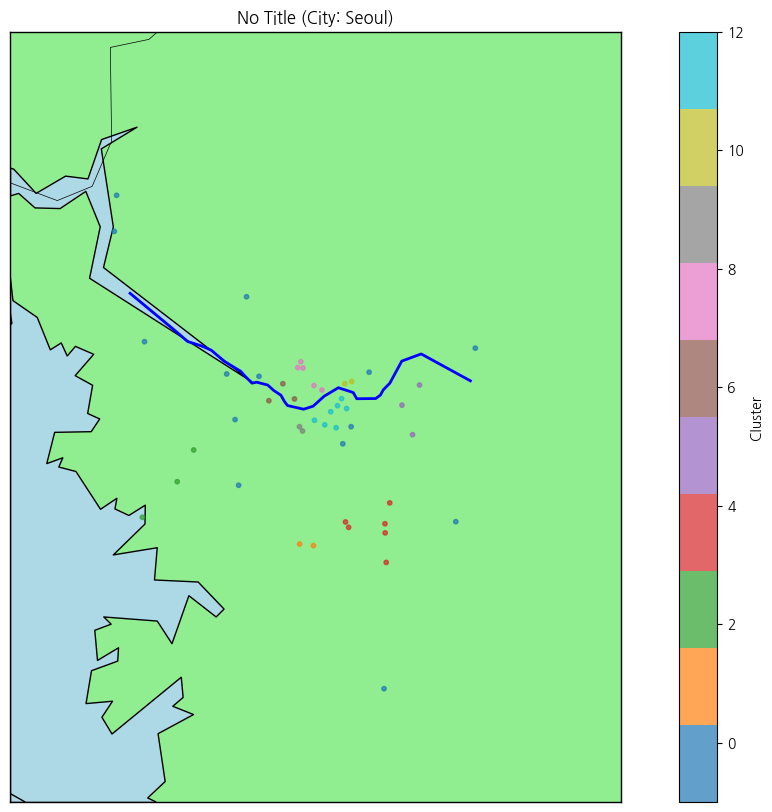

In [103]:
date_plot = '2024-01-05'
df_plot = df.query('date == @date_plot')
plot_orders(df_plot, color_by_cluster=True, city='Seoul', cmap='tab10', figsize=(15,10), zoom_ratio=1.5)

In [ ]:
# imports.
from datetime import datetime
from scipy.cluster.hierarchy import linkage, fcluster
import os

# Load.
df_100yrs   = pd.read_excel('./data/20250127_100yrs_Order_List_20250124.xlsx', sheet_name=None)  # '20250123' and '20250124' sheets.

# Copy.
df_list = df_100yrs.copy()   # Separate sheet for each date, e.g. df_list['20250123'].

# Arguments.
min_samples_to_cluster = 3   # If num of orders in specific time is smaller than this (not inclusive), don't cluster.
not_clustered_too_few  = -1  # Code for not clustered samples because of the small size.

# For each date,
for sheet, df in df_list.items():
    print(f'Date: {sheet}.')
    # Get unique time.
    df = df.rename(columns={'date': 'time'})
    unique_times = df['time'].unique()
    
    # Initialize an empty DataFrame to collect results.
    all_results = pd.DataFrame()
    
    # Iterate over each time and perform clustering.
    for specific_time in unique_times:
        print(f'Time: {specific_time}')
        sample_df = df[df['time'] == specific_time].copy()

        # Don't cluster if orders are too few.
        if len(sample_df) < min_samples_to_cluster:
            sample_df['cluster'] = not_clustered_too_few
            all_results          = pd.concat([all_results, sample_df], ignore_index=True)
            continue

        # Set coordinates.
        coords = sample_df[['latitude', 'longitude']]
    
        # Perform hierarchical clustering.
        Z = linkage(coords, method='ward')
    
        # Dynamically calculate n_clusters.
        max_n_clusters        = 20 + 1    # Upper bound for n_clusters, '20'.
        clusters_orders_ratio = 0.4       # Percentage of n_orders for n_clusters.
        n_clusters = min(int(clusters_orders_ratio * len(sample_df)), max_n_clusters)   # clusters_orders_ratio * n_orders at that day.

        # If there are not enough clusters, set the number of clusters to the maximum possible.
        if len(Z) < (n_clusters - 1):
            n_clusters = len(Z) + 1
    
        # Dynamically calculate the distance threshold.
        distance_threshold = Z[-(n_clusters - 1), 2]
    
        # Assign clusters with appended date information.
        sample_df['cluster'] = fcluster(Z, t=distance_threshold, criterion='distance')

        # Plot.
        specific_time = specific_time.replace(':', '_')
        plot_orders(
            sample_df,
            color_by_cluster=True,
            figsize=(12, 8),
            title=f'result_{sheet}_{specific_time}',
            cmap='tab20',
            city='Seoul',
            save_image=True
        )
        
        # Append the result.
        all_results = pd.concat([all_results, sample_df], ignore_index=True)
    
    # Sort the combined results by 'time' first and then by 'cluster'.
    all_results.sort_values(by=['time', 'cluster'], inplace=True)
    
    # Save the combined results to a CSV file.
    cur_time = datetime.now().strftime("%Y_%m%d_%H_%M_%S")
    result_folder_path = os.path.join("tmp", cur_time)
    os.makedirs(result_folder_path, exist_ok=True)
    
    results_path = result_folder_path + '/results_100yrs_' + str(sheet) + '.csv'
    all_results.to_csv(results_path, index=False, encoding='utf-8-sig')
    
    print("Clustering results saved to " + results_path + ".\n")
